# komet : Kronecker Optimized METhod for DTI prediction

In this TP, we will present the LCIdb database and the Komet algorithm.

1. Downloading utils and the dataset (train/val/test) from Github
2. Calculation of molecule features using a subsample of train molecules (MorganFP kernel approximated via Nystrom approximation)
3. Calculation of protein features (SVD on LAkernel)
4. Train/Testing with a chosen lambda
5. Make some predictions

In [2]:
%load_ext autoreload
%autoreload 2

# Importing the current libraries

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import zipfile
import pickle
import time

from sklearn.metrics import  average_precision_score,  roc_curve, confusion_matrix, precision_score, recall_score, auc

In [3]:
# Importing the pytorch libraries and define the device

import torch
import torch.optim as optim

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device_cpu = torch.device("cpu")
device_cpu = device
print( device )

mytype = torch.float16 # to save memory (only on GPU)
mytype = torch.float32

cuda:0


### 0. Presentation of the rdkit library

In [4]:
!pip install rdkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.2/34.2 MB 45.8 MB/s eta 0:00:00


**Question 1** Consult the following [link](https://www.rdkit.org/docs/GettingStartedInPython.html) and draw the aspirin molecule in the code box below.

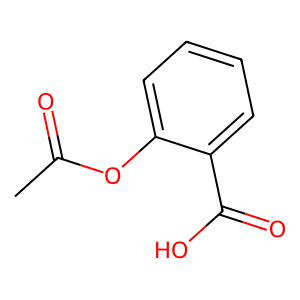

In [5]:
# correction
from rdkit import Chem
asp =  Chem.MolFromSmiles('CC(=O)OC1=CC=CC=C1C(=O)O') #https://pubchem.ncbi.nlm.nih.gov/compound/Aspirin
from rdkit.Chem import Draw
Draw.MolToImage(asp)

### 1. Download the data from a GitHub repo.

#### Download utils

In [6]:
!wget -q https://github.com/Guichaoua/komet/raw/main/komet/komet.py

In [7]:
import komet

cuda:0


**Question 2** In the file icon on the left, download the komet.py file and observe its structure.

correction: Python file with the functions that are used in this notebook.

#### Download train/val/test

In [8]:
!mkdir data/
!wget -q https://github.com/Guichaoua/komet/raw/main/data/LCIdb/Orphan/dict_ind2fasta_LCIdb.data
!mv dict_ind2fasta_LCIdb.data data/
!wget -q https://github.com/Guichaoua/komet/raw/main/data/LCIdb/Orphan/dict_ind2fasta_LCIdb_K_prot.data
!mv dict_ind2fasta_LCIdb_K_prot.data data/
!wget -q https://github.com/Guichaoua/komet/raw/main/data/LCIdb/Orphan/test.csv
!mv test.csv data/
!wget -q https://github.com/Guichaoua/komet/raw/main/data/LCIdb/Orphan/train.csv.zip
!mv train.csv.zip data/
!wget -q https://github.com/Guichaoua/komet/raw/main/data/LCIdb/Orphan/val.csv
!mv val.csv data/

**Question 3** Check that the files have been uploaded successfully in data file.

correction: data folder with 5 files.

In [9]:
dataset_dir = "data/"

# load data
train = komet.load_df("train.csv.zip",dataset_dir)
val = komet.load_df("val.csv",dataset_dir)
test = komet.load_df("test.csv",dataset_dir)

# dataframe full has all smiles and fasta sequences
full = pd.concat([train, val, test])
print("full shape",full.shape)

[12:44:34] Explicit valence for atom # 5 P, 7, is greater than permitted
[12:44:34] Explicit valence for atom # 23 P, 7, is greater than permitted
[12:44:35] Explicit valence for atom # 19 P, 7, is greater than permitted
[12:44:36] Explicit valence for atom # 10 P, 7, is greater than permitted
[12:44:36] Explicit valence for atom # 5 P, 7, is greater than permitted
[12:44:36] Explicit valence for atom # 16 P, 7, is greater than permitted
[12:44:36] Explicit valence for atom # 20 P, 7, is greater than permitted
[12:44:38] Explicit valence for atom # 5 P, 7, is greater than permitted
[12:44:38] Explicit valence for atom # 9 P, 7, is greater than permitted
[12:44:38] Explicit valence for atom # 5 P, 7, is greater than permitted
[12:44:38] Explicit valence for atom # 10 P, 7, is greater than permitted
[12:44:40] Explicit valence for atom # 17 P, 7, is greater than permitted
[12:44:40] Explicit valence for atom # 10 P, 7, is greater than permitted
[12:44:41] Explicit valence for atom # 10 P

number of smiles to clean: 35
train.csv shape (236396, 3)


[12:45:04] Explicit valence for atom # 43 P, 7, is greater than permitted
[12:45:07] Explicit valence for atom # 8 P, 7, is greater than permitted
[12:45:08] Explicit valence for atom # 20 P, 7, is greater than permitted
[12:45:09] Explicit valence for atom # 11 P, 7, is greater than permitted


number of smiles to clean: 4
val.csv shape (21839, 3)


[12:45:14] Explicit valence for atom # 19 P, 7, is greater than permitted
[12:45:17] Explicit valence for atom # 18 P, 7, is greater than permitted
[12:45:17] Explicit valence for atom # 16 P, 7, is greater than permitted
[12:45:17] Explicit valence for atom # 16 P, 7, is greater than permitted
[12:45:17] Explicit valence for atom # 1 P, 7, is greater than permitted
[12:45:17] Explicit valence for atom # 16 P, 7, is greater than permitted
[12:45:17] Explicit valence for atom # 18 P, 7, is greater than permitted
[12:45:17] Explicit valence for atom # 9 P, 7, is greater than permitted
[12:45:19] Explicit valence for atom # 17 P, 7, is greater than permitted
[12:45:20] Explicit valence for atom # 8 P, 7, is greater than permitted
[12:45:20] Explicit valence for atom # 4 P, 7, is greater than permitted


number of smiles to clean: 11
test.csv shape (44985, 3)
full shape (303220, 3)


**Question 4**
1. Go to the komet.py file to see what the `load_df` function does.
2. What is the type of train? Show first lines. How many values ​​for the Label?

When the SMILES string is improperly encoded, the function `Chem.MolFromSmiles()` returns `None`. We remove the pairs that correspond to these molecules.

In [10]:
# correction
train.head() #pd.DataFrame
train["Label"].value_counts()

,count
Label,
1,118198
0,118198


### 2. Calculation of molecule features using a subsample of train molecules (molecule kernel approximated via Nystrom approximation)


In [11]:
#### MOLECULE####

list_smiles = full[['SMILES']].drop_duplicates().values.flatten()
nM = len(list_smiles)
print("number of different smiles (mol):",nM)

# add indsmiles in train, val, test
#dict_ind2smiles = {i:list_smiles[i] for i in range(nM)}
dict_smiles2ind = {list_smiles[i]:i for i in range(nM)}
train['indsmiles'] = train['SMILES'].apply(lambda x:dict_smiles2ind[x] )
val['indsmiles'] = val['SMILES'].apply(lambda x: dict_smiles2ind[x])
test['indsmiles'] = test['SMILES'].apply(lambda x: dict_smiles2ind[x])

number of different smiles (mol): 143206


In [12]:
# molecule kernel_first step : compute Morgan FP for each smiles of all the dataset
MorganFP = komet.Morgan_FP(list_smiles)

**Question 5**
What are the dimensions of `MorganFP` ? Plot Morgan FP for the first molecule.

For more [details on Morgan FP](https://chemicbook.com/2021/03/25/a-beginners-guide-for-understanding-extended-connectivity-fingerprints.html).

torch.Size([143206, 1024])


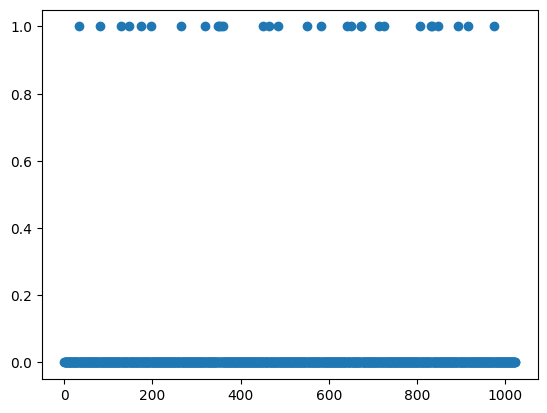

In [13]:
print(MorganFP.shape)
plt.scatter(range(1024),MorganFP[0,:].cpu())

In [14]:
# Choice of the parameters for the Nystrom approximation and the reduction dimension of the features
mM = 3000 #all mol to compute the mol kernel for medium-scale database
dM = 1000 #all dim for the mol features for medium-scale database

# In case there are less molecules than the number of molecules to compute the Nystrom approximation
mM = min(mM,nM) # number of molecule to compute nystrom
dM = min(dM,nM) # final dimension of features for molecules
print("mM",mM,"dM",dM)

mM 3000 dM 1000


In [15]:
# compute the Nystrom approximation of the mol kernel and the features of the Kronecker kernel (features normalized and calculated on all mol contained in the dataset (train/val/test))
X_cn = komet.Nystrom_X_cn(mM,dM,nM,MorganFP,n_max = max(train['indsmiles']))
print("mol features shape",X_cn.shape)

mol kernel shape torch.Size([3000, 143206])
mol features shape torch.Size([143206, 1000])


**Question 6**
1. Understand the different steps of the function `Nystrom_X_cn`, in particular explain the formula for Tanimoto kernel.
1. What are the dimensions of `X_cn` ? Plot features for the first molecule.


X_cn torch.Size([143206, 1000])


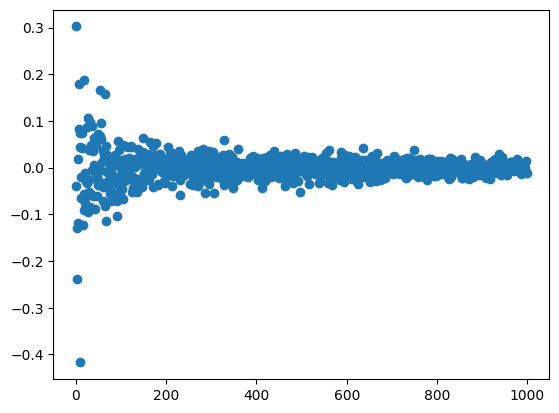

In [16]:
print("X_cn",X_cn.shape)
plt.scatter(range(1000),X_cn[0,:].cpu())

### 3. Calculation of protein features

In [17]:
# Index of the protein in the dataset
fasta = full[['Target Sequence']].drop_duplicates().values.flatten() # fasta sequence on the dataset, in the same order as the dataset
print("number of different Fasta (protein):",len(fasta))
# add ind_fasta dans train, val et test
train['indfasta'] = train['Target Sequence'].apply(lambda x: np.where(fasta==x)[0][0])
val['indfasta'] = val['Target Sequence'].apply(lambda x: np.where(fasta==x)[0][0])
test['indfasta'] = test['Target Sequence'].apply(lambda x:  np.where(fasta==x)[0][0])

number of different Fasta (protein): 2069


In [18]:
# Load Protein kernel and dictionary of index
dict_ind2fasta_LCIdb = pickle.load(open(dataset_dir + "dict_ind2fasta_LCIdb.data", 'rb'))
dict_fasta2ind_LCIdb = {fasta:ind for ind,fasta in dict_ind2fasta_LCIdb.items()}
with open(dataset_dir + "dict_ind2fasta_LCIdb_K_prot.data", 'rb') as f:
    KP_LCIdb = pickle.load(f)

In [19]:
# Protein kernel for the dataset
I_fasta = [int(dict_fasta2ind_LCIdb[fasta[i]]) for i in range(len(fasta))] # index of fasta in the precomputed dict and protein kernel, in the same order as the dataset
KP = KP_LCIdb[I_fasta,:][:,I_fasta]
KP = torch.tensor(KP, dtype=mytype).to(device)

In [20]:
# computation of feature for protein (no nystrom, just SVD)
rP = KP.shape[0]#min(KP.shape[0],500)
U, Lambda, VT = torch.svd(KP)
Y = U[:,:rP] @ torch.diag(torch.sqrt(Lambda[:rP]))

# nomramlisation of the features
n_max = max(train['indfasta'])
Y_c = Y - Y[:n_max,:].mean(axis = 0)
Y_cn = Y_c / torch.norm(Y_c,dim = 1)[:,None]

**Question 7**
1. What are the dimensions of  `KP`? and `Y_cn`?
2. Can we easily modify the dimensions of protein features ?

torch.Size([2069, 2069]) torch.Size([2069, 2069])


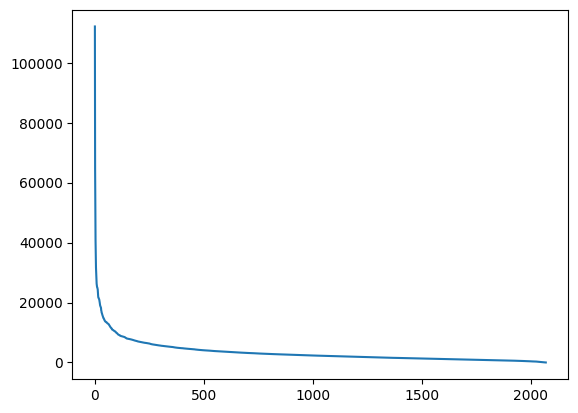

In [21]:
print(KP.shape,Y_cn.shape)
# we can change rP
plt.plot(Lambda.cpu())

### Load interactions index for train and test

In [22]:
# Train
I, J, y = komet.load_datas(train)
n = len(I)
print("len(train)",n)

len(train) 236396


**Question 7**
What are `I`, `J`, `y` ?

In [23]:
I.shape,J.shape,y.shape

(torch.Size([236396]), torch.Size([236396]), torch.Size([236396]))

In [24]:
I[:10],J[:10],y[:10]
# I,J indices of the molecules and proteins in the dataset
# y the labels

(tensor([0, 0, 0, 0, 0, 0, 1, 1, 1, 1], device='cuda:0'),
 tensor([0, 1, 2, 3, 4, 5, 0, 6, 7, 8], device='cuda:0'),
 tensor([ 1., -1.,  1., -1.,  1., -1.,  1.,  1., -1., -1.], device='cuda:0',
        dtype=torch.float64))

In [25]:
# Test
I_test, J_test, y_test = komet.load_datas(test)
n_test = len(I_test)
print("len(test)",n_test)

len(test) 44985


In [26]:
I_test[:10],J_test[:10],y_test[:10]

(tensor([108143, 108143, 108144, 108144, 108145, 108146, 108146, 104746, 108147,
         108147], device='cuda:0'),
 tensor([1898, 1528, 1898, 1528, 1898, 1898, 1654, 1898, 1898, 2058],
        device='cuda:0'),
 tensor([ 1.,  1.,  1.,  1.,  1.,  1., -1.,  1.,  1.,  1.], device='cuda:0',
        dtype=torch.float64))

**Question 8**
This dataset is named Orphan because none of the molecules present in a pair of the train, are present in the test, same for proteins. Can you check it ?

In [27]:
np.intersect1d(I_test.cpu(),I.cpu()).shape, np.intersect1d(J_test.cpu(),J.cpu()).shape

((0,), (0,))

### Training/Testing with a choosen lambda

In [28]:
#### TRAINING ####
lamb = 1e-6
# train the model
w_bfgs,b_bfgs,history_lbfgs_SVM = komet.SVM_bfgs(X_cn,Y_cn,y,I,J,lamb,niter=70)
# compute a probability using weights (Platt scaling)
s,t,history_lbfgs_Platt = komet.compute_proba_Platt_Scalling(w_bfgs,X_cn,Y_cn,y,I,J,niter=30)

L-BFGS time: 19.3570 seconds


**Question 9**
1. Explains the different steps of the function `SVM_bfgs`.
2. Plot `history_lbfgs_SVM` and explain the graphic.

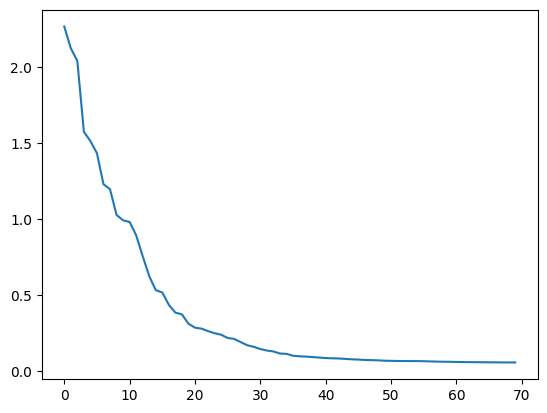

In [29]:
plt.plot(history_lbfgs_SVM)

In [30]:
#### TRAIN ####
# we compute a probability using weights (Platt scaling)
m_train,y_pred_train, proba_pred_train = komet.compute_proba(w_bfgs,b_bfgs,s,t,X_cn,Y_cn,I,J)
# we compute the results
acc1_train,au_Roc_train,au_PR_train,thred_optim_train,acc_best_train,cm_train,FP_train = komet.results(y.cpu(),y_pred_train.cpu(),proba_pred_train.cpu())
print(f"roc AUC = {au_Roc_train:.4f}")
print(f"AUPR = {au_PR_train:.4f}")
print(f"accuracy (threshold 0.5)= {acc1_train:.4f}")
print(f"best threshold = {thred_optim_train:.4f}")
print(f"accuracy (best threshold)= {acc_best_train:.4f}")
print(f"false positive (best threshold)= {FP_train:.4f}")

roc AUC = 0.9995
AUPR = 0.9990
accuracy (threshold 0.5)= 0.9978
best threshold = 0.4200
accuracy (best threshold)= 0.9978
false positive (best threshold)= 0.0031


In [31]:
#### TEST ####
# we compute a probability using weights (Platt scaling)
m,y_pred, proba_pred = komet.compute_proba(w_bfgs,b_bfgs,s,t,X_cn,Y_cn,I_test,J_test)
# we compute the results
acc1,au_Roc,au_PR,thred_optim,acc_best,cm,FP = komet.results(y_test.cpu(),y_pred.cpu(),proba_pred.cpu())
print(f"roc AUC = {au_Roc:.4f}")
print(f"AUPR = {au_PR:.4f}")
print(f"accuracy (threshold 0.5)= {acc1:.4f}")
print(f"best threshold = {thred_optim:.4f}")
print(f"accuracy (best threshold)= {acc_best:.4f}")
print(f"false positive (best threshold)= {FP:.4f}")

roc AUC = 0.8829
AUPR = 0.8973
accuracy (threshold 0.5)= 0.6832
best threshold = 0.0011
accuracy (best threshold)= 0.8133
false positive (best threshold)= 0.1614


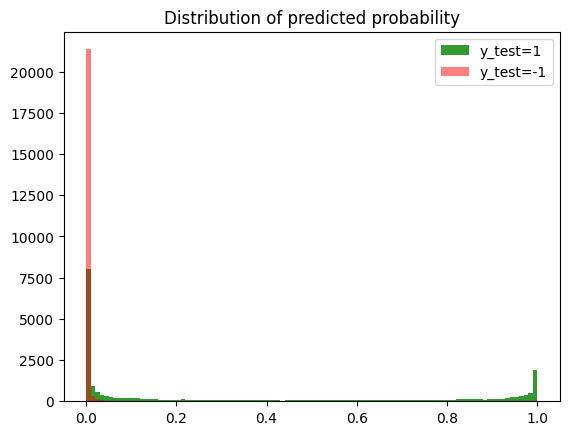

In [32]:
# plot distribution (density) of p when y_test=1
plt.hist(proba_pred.cpu().numpy()[y_test.cpu().numpy()==1],bins=100,alpha=0.8,color='green',label='y_test=1');
plt.hist(proba_pred.cpu().numpy()[y_test.cpu()==-1],bins=100,alpha=0.5,color='red',label='y_test=-1');
plt.legend()
plt.title('Distribution of predicted probability')
plt.show()

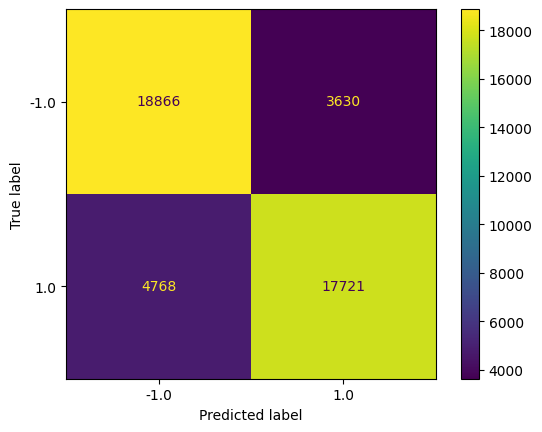

In [33]:
# plot confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay
labels = [-1., 1.]
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=labels)
disp.plot()
plt.show()

**Question 10**
Comments the code and different results.

The performances are very good on the train, with a risk of overfitting. The marked gap between the train and test scores confirms the difficulty of the model to generalize.
The optimal threshold is very different between train and test, the distribution of probabilities is radically different on the test data. The model must lower its threshold to predict more positives which we see in the distribution plot.

We remind you that this case of DTI prediction is very difficult because neither the molecules nor the proteins are the same in the train and the test. Research is active to find better models in these cases.

In [34]:
YJ = Y_cn[J, :]
print(Y_cn.shape,YJ.shape)
# in the komet code : torch.sum((Y_cn @ w)[J, :] * XI , axis=1) is faster than torch.sum(YJ @ w * XI , axis=1) considering the size of YJ

torch.Size([2069, 2069]) torch.Size([236396, 2069])


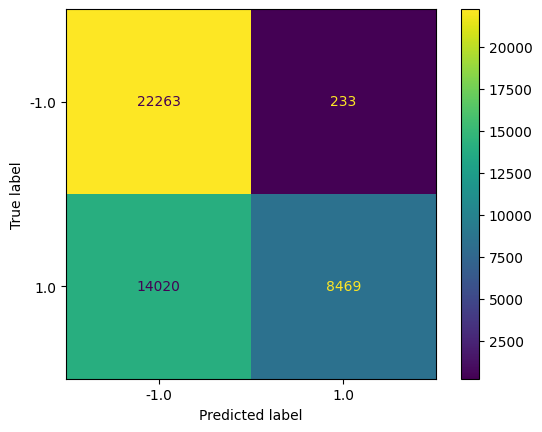

In [35]:
# Confusion matrix with thershold = 0.5:
# few False positive (good when we have to do in vitro tests )
#
cm2 = confusion_matrix(y_test.cpu(), y_pred.cpu())
# plot confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay
labels = [-1., 1.]
disp = ConfusionMatrixDisplay(confusion_matrix=cm2,
                              display_labels=labels)
disp.plot()
plt.show()

###
**Question 11**
1. Is the aspirin molecule in train/val/test ?
2. Train the model with the full dataset.
3. Predict for the aspirin molecule, protein(s) which bind with.
4. Compare with Targets of the [Drugbank database](https://go.drugbank.com/drugs/).

In [36]:
#1. Is the aspirin molecule in train/val/test

asp_smiles = 'CC(=O)OC1=CC=CC=C1C(=O)O'
asp_smiles in dict_smiles2ind

False

In [37]:
# similarity with molecules in full dataset
sim = (MorganFP[:-1] @ MorganFP[-1].T ) / ( 1024 - (1-MorganFP[:-1]) @ (1-MorganFP[-1].T))
print(torch.max(sim),torch.argmax(sim))
# Aspirin is not in the dataset and is even quite far from the molecules that are there. It is not a trivial example.

tensor(0.6452, device='cuda:0') tensor(12388, device='cuda:0')


<ipython-input-37-34665d21836f>:2: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3683.)
  sim = (MorganFP[:-1] @ MorganFP[-1].T ) / ( 1024 - (1-MorganFP[:-1]) @ (1-MorganFP[-1].T))


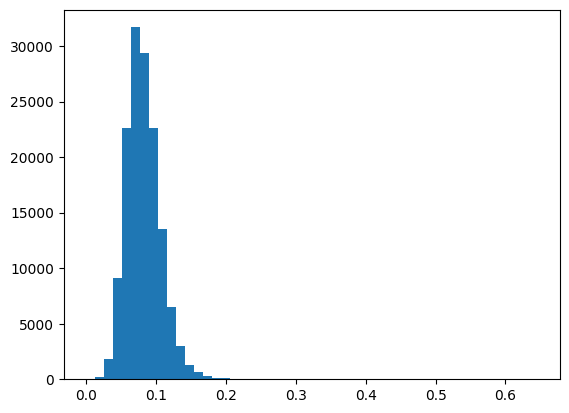

In [38]:
plt.hist(sim.cpu(),bins=50);

In [39]:
#2. Prediction of the aspirin molecule

# compute the feature of the aspirin molecule
asp_fp = komet.Morgan_FP([asp_smiles])
MorganFP = torch.concat((MorganFP,asp_fp))
X_cn = komet.Nystrom_X_cn(mM,dM,nM+1,MorganFP, n_max = nM)

mol kernel shape torch.Size([3000, 143207])


In [40]:
# train the model on the full dataset

I_train, J_train, y_train = komet.load_datas(train)
n_train = len(I_train)
I_val, J_val, y_val = komet.load_datas(val)
n_val = len(I_val)
I_test, J_test, y_test = komet.load_datas(test)
n_test = len(I_test)
I_full = torch.concat((I_train,I_val,I_test))
J_full = torch.concat((J_train,J_val,J_test))
y_full = torch.concat((y_train,y_val,y_test))

In [41]:
# training
lamb = 1e-6
w_bfgs,b_bfgs,history_lbfgs_SVM = komet.SVM_bfgs(X_cn,Y_cn,y_full,I_full,J_full,lamb,niter=50)
# compute a probability using weights (Platt scaling)
s,t,history_lbfgs_Platt = komet.compute_proba_Platt_Scalling(w_bfgs,X_cn,Y_cn,y_full,I_full,J_full,niter=20)

L-BFGS time: 15.4312 seconds


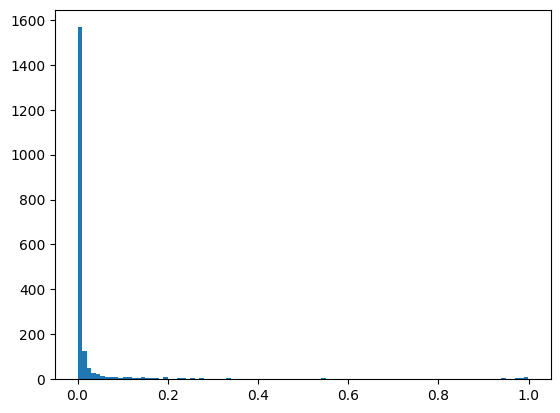

In [42]:
# compute the probability of the aspirin molecule on protein of the protein dataset (in train and test)
ind_asp = X_cn.shape[0] - 1
m_asp,y_pred_asp, proba_pred_asp = komet.compute_proba(w_bfgs,b_bfgs,s,t,X_cn,Y_cn,[ind_asp],range(Y_cn.shape[0]))
plt.hist(proba_pred_asp.cpu(), bins=100);

In [43]:
pd_result = pd.DataFrame({'fasta':dict_ind2fasta_LCIdb.values() ,'proba':proba_pred_asp.cpu(), 'y_pred_asp':y_pred_asp.cpu()})
pd_result = pd_result.sort_values(by='proba',ascending=False)
pd_result.head()

,fasta,proba,y_pred_asp
240,MPGMVLFGRRWAIASDDLVFPGFFELVVRVLWWIGILTLYLMHRGK...,0.999801,1.0
2,MAPPSEETPLIPQRSCSLLSTEAGALHVLLPARGPGPPQRLSFSFG...,0.999560,1.0
442,MWELVALLLLTLAYLFWPKRRCPGAKYPKSLLSLPLVGSLPFLPRH...,0.999322,1.0
6,MLLSKINSLAHLRAAPCNDLHATKLAPGKEKEPLESQYQVGPLLGS...,0.997636,1.0
35,MHSKVTIICIRFLFWFLLLCMLIGKSHTEDDIIIATKNGKVRGMNL...,0.996996,1.0


In [44]:
!wget -q https://github.com/Guichaoua/komet/raw/main/data/prot_uniprot_fasta_all.csv
!mv prot_uniprot_fasta_all.csv data/

In [45]:
pd_fasta = pd.read_csv('data/prot_uniprot_fasta_all.csv')
pd_fasta.head()

,Target,Match type,Approved symbol,Approved name,HGNC ID,uniprot,fasta
0,a2m,Approved symbol,A2M,alpha-2-macroglobulin,HGNC:7,P01023,MGKNKLLHPSLVLLLLVLLPTDASVSGKPQYMVLVPSLLHTETTEK...
1,aadac,Approved symbol,AADAC,arylacetamide deacetylase,HGNC:17,P22760,MGRKSLYLLIVGILIAYYIYTPLPDNVEEPWRMMWINAHLKTIQNL...
2,aadat,Approved symbol,AADAT,aminoadipate aminotransferase,HGNC:17929,Q8N5Z0,MNYARFITAASAARNPSPIRTMTDILSRGPKSMISLAGGLPNPNMF...
3,aak1,Approved symbol,AAK1,AP2 associated kinase 1,HGNC:19679,Q2M2I8,MKKFFDSRREQGGSGLGSGSSGGGGSTSGLGSGYIGRVFGIGRQQV...
4,aanat,Approved symbol,AANAT,aralkylamine N-acetyltransferase,HGNC:19,Q16613,MSTQSTHPLKPEAPRLPPGIPESPSCQRRHTLPASEFRCLTPEDAV...


In [46]:
pd_result = pd_result.merge(pd_fasta)
pd_result.drop(columns=['Match type'],inplace=True)
pd_result.head(10)

,fasta,proba,y_pred_asp,Target,Approved symbol,Approved name,HGNC ID,uniprot
0,MPGMVLFGRRWAIASDDLVFPGFFELVVRVLWWIGILTLYLMHRGK...,0.999801,1.0,daglb,DAGLB,diacylglycerol lipase beta,HGNC:28923,Q8NCG7
1,MAPPSEETPLIPQRSCSLLSTEAGALHVLLPARGPGPPQRLSFSFG...,0.999560,1.0,jak3,JAK3,Janus kinase 3,HGNC:6193,P52333
2,MWELVALLLLTLAYLFWPKRRCPGAKYPKSLLSLPLVGSLPFLPRH...,0.999322,1.0,cyp17a1,CYP17A1,cytochrome P450 family 17 subfamily A member 1,HGNC:2593,P05093
3,MLLSKINSLAHLRAAPCNDLHATKLAPGKEKEPLESQYQVGPLLGS...,0.997636,1.0,pim1,PIM1,"Pim-1 proto-oncogene, serine/threonine kinase",HGNC:8986,P11309
4,MHSKVTIICIRFLFWFLLLCMLIGKSHTEDDIIIATKNGKVRGMNL...,0.996996,1.0,bche,BCHE,butyrylcholinesterase,HGNC:983,P06276
5,MATEEKKPETEAARAQPTPSSSATQSKPTPVKPNYALKFTLAGHTK...,0.996534,1.0,wdr5,WDR5,WD repeat domain 5,HGNC:12757,P61964
6,MLARALLLCAVLALSHTANPCCSHPCQNRGVCMSVGFDQYKCDCTR...,0.995244,1.0,ptgs2,PTGS2,prostaglandin-endoperoxide synthase 2,HGNC:9605,P35354
7,MAGGPGPGEPAAPGAQHFLYEVPPWVMCRFYKVMDALEPADWCQFA...,0.994930,1.0,irak1,IRAK1,interleukin 1 receptor associated kinase 1,HGNC:6112,P51617
8,MVQKSRNGGVYPGPSGEKKLKVGFVGLDPGAPDSTRDGALLIAGSE...,0.991114,1.0,kcnq2,KCNQ2,potassium voltage-gated channel subfamily Q me...,HGNC:6296,O43526
9,MEPSSWSGSESPAENMERMSDSADKPIDNDAEGVWSPDIEQSFQEA...,0.989426,1.0,tead1,TEAD1,TEA domain transcription factor 1,HGNC:11714,P28347


In [48]:
# comparison with Drugbank targets where binding affinity can be shown, we find only one target on the 2.
pd_result[pd_result['Target'].isin(['ptgs1','ptgs2'])]

,fasta,proba,y_pred_asp,Target,Approved symbol,Approved name,HGNC ID,uniprot
6,MLARALLLCAVLALSHTANPCCSHPCQNRGVCMSVGFDQYKCDCTR...,0.995244,1.0,ptgs2,PTGS2,prostaglandin-endoperoxide synthase 2,HGNC:9605,P35354
1587,MSRSLLLWFLLFLLLLPPLPVLLADPGAPTPVNPCCYYPCQHQGIC...,0.000071,-1.0,ptgs1,PTGS1,prostaglandin-endoperoxide synthase 1,HGNC:9604,P23219


When we train our model on the entire database and not this subset named Orphan, we found the 2 targets: see https://komet.readthedocs.io/en/latest/vignettes/komet%20prediction.html